In [21]:
#----------------------------#
# 0.) Idea
#----------------------------#
# Analyze Get submssion deletion boundaries
#

#
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import import_ipynb
import math

In [22]:
home_path = %pwd
data_path = "/home/pavel/Documents/Keusch_Job/Data/"
plot_path  = "/home/pavel/Documents/Keusch_Job/Tasks/deletion_boundaries/"
subroutines_path = "/home/pavel/Documents/Keusch_Job/Subroutines/"

In [23]:
#Subroutines
%cd  $subroutines_path
%run "selected_subreddits.ipynb"
%run "data_loader.ipynb"
%run "basic_plots.ipynb"
%cd  $home_path

/home/pavel/Documents/Keusch_Job/Subroutines
/home/pavel/Documents/Keusch_Job/Tasks/deletion_boundaries


In [24]:
S = load_data(data_name="SUBM_2020_01.csv", data_path = data_path)
S.head()

,author,created_utc,domain,full_link,id,is_crosspostable,is_self,is_video,num_comments,post_hint,score,selftext,subreddit,title,url,removed_by_category,link_flair_text
0,sixwaystop313,2019-12-31 22:03:48,imgur.com,https://www.reddit.com/r/Michigan/comments/ei8...,t3_ei8t50,True,False,False,8,link,1,NaN,Michigan,TIL in Traverse City skateboards and rollerbla...,https://imgur.com/JCMkFWh,NaN,NaN
1,livya15,2019-12-31 23:15:10,self.Michigan,https://www.reddit.com/r/Michigan/comments/ei9...,t3_ei9p65,True,True,False,0,NaN,1,https://www.facebook.com/83040292558/posts/101...,Michigan,Could you imagine if a sign like this was post...,https://www.reddit.com/r/Michigan/comments/ei9...,NaN,NaN
2,livya15,2020-01-01 00:03:54,nbc25news.com,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaaut,True,False,False,1,link,1,NaN,Michigan,Could you imagine if there was a sign placed a...,https://nbc25news.com/news/local/lapeer-county...,NaN,NaN
3,lishmunchkin,2020-01-01 00:10:24,self.Michigan,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaduh,True,True,False,4,NaN,1,Hubby and I are moving to Michigan in 2 weeks ...,Michigan,Hoping the new year brings good things!,https://www.reddit.com/r/Michigan/comments/eia...,NaN,NaN
4,DonSlice,2020-01-01 00:35:11,i.imgur.com,https://www.reddit.com/r/Michigan/comments/eia...,t3_eiaow3,True,False,False,6,NaN,1,NaN,Michigan,"Welcome back, Winter. You’ve been gone a while.",https://i.imgur.com/LZcd5IR.jpg,NaN,NaN


In [25]:
#----------------------------#
# 1.)  Prob deletion Descriptives
#----------------------------#

In [26]:
# I would argue to keep automod_filtered, since it is still set by the mods from what I see
#https://www.reddit.com/r/AutoModerator/comments/q11pu/what_is_automoderator/
# "Remove submissions where the title contains certain words or phrases"
#Some basic Stats
print("Length of Submission Data: " + str(len(S)))
print("Passible removed_by_category outputs" + str(S["removed_by_category"].unique()))
S_grouped = S.groupby(["removed_by_category"]).size().reset_index()
print(S_grouped.to_string())
print("Amount deleted: " + str(S_grouped[0].sum()))

Length of Submission Data: 404631
Passible removed_by_category outputs[nan 'moderator' 'reddit' 'deleted' 'automod_filtered' 'author']
  removed_by_category      0
0              author      8
1    automod_filtered  13926
2             deleted   5511
3           moderator  61406
4              reddit  37437
Amount deleted: 118288


In [27]:
S["removed"] = 1 
S.loc[S["removed_by_category"].isna(),"removed"] = 0 
S_grouped = S.groupby(["subreddit","removed"]).size().reset_index()
S_grouped.columns = ["subreddit","removed","count"]
print(len(S_grouped.loc[S_grouped["removed"] == 1,]))
print(len(S_grouped.loc[S_grouped["removed"] == 0,]))
print("Each subreddit has deleted at least one submission")

78
78
Each subreddit has deleted at least one submission


In [28]:
#
S["removed_automod"] = 0
S.loc[S["removed_by_category"] == "automod_filtered","removed_automod"] = 1
print(S["removed_automod"].unique())
#
S["removed_deleted"] = 0
S.loc[S["removed_by_category"] == "deleted","removed_deleted"] = 1
print(S["removed_deleted"].unique())
#
S["removed_moderator"] = 0
S.loc[S["removed_by_category"] == "moderator","removed_moderator"] = 1
print(S["removed_moderator"].unique())
#
S["removed_reddit"] = 0
S.loc[S["removed_by_category"] == "reddit","removed_reddit"] = 1
print(S["removed_reddit"].unique())

[0 1]
[0 1]
[0 1]
[0 1]


In [29]:
#----------------------------#
# 2.) Get Embeddings and PCA Data
#----------------------------#

In [30]:
# I've computed this back then in subreddit_submission
embed_dict = np.load(data_path + 'embed_dict.npy',allow_pickle='TRUE').item()

In [31]:
def get_subreddit_embeddings(c_S):
    #c_S: current subreddit
    local_embed_list = []
    id_list = c_S["id"].unique().tolist()
    [local_embed_list.append(embed_dict[x]) for x in id_list]
    return(local_embed_list)

In [32]:
def subr_dict_2_matrix(s_dict, key_list):
    #s_dict: some dictionary where the values are embedings ()
    #key_list: a list of keys
    #RETURNS: the np.array matrix where each value is a row.
    emb_matrix = np.append(s_dict[key_list[0]], s_dict[key_list[1]],axis=0)
    for i in range(2,len(key_list)):
        emb_matrix = np.append(emb_matrix, s_dict[key_list[i]],axis=0)
    return(emb_matrix)

In [33]:
from sklearn.decomposition import PCA

In [34]:
def PCA_data(subr_string):
    #Get DF's
    sub_df = S.loc[S["subreddit"]==subr_string,].copy()
    sub_emb_matrix  = subr_dict_2_matrix(s_dict = embed_dict, key_list= sub_df["id"].tolist()).T
    print(sub_emb_matrix.shape)  
    #PCA
    model = PCA(n_components=2).fit(sub_emb_matrix)
    category_vectors = model.components_.T
    sub_df["dim_x_PCA"] = category_vectors[:,0].tolist()
    sub_df["dim_y_PCA"] = category_vectors[:,1].tolist()
    #sub_df[["id","removed","dim_x_PCA","dim_y_PCA"]]
    return(sub_df)

In [35]:
democrats_df = PCA_data("democrats")

(512, 1439)


In [36]:
#thx https://pythonspot.com/matplotlib-scatterplot/
# Create data
#N = 60
#g1 = (0.6 + 0.6 * np.random.rand(N), np.random.rand(N))
#g2 = (0.4+0.3 * np.random.rand(N), 0.5*np.random.rand(N))
#g3 = (0.3*np.random.rand(N),0.3*np.random.rand(N))
#
#data = (g1, g2, g3)
#colors = ("red", "green", "blue")
#groups = ("coffee", "tea", "water")#
#
## Create plot
#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
#for data, color, group in zip(data, colors, groups):
#    x, y = data
#    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)#
#
#plt.title('Matplot scatter plot')
#plt.legend()
#plt.show()
#

In [37]:
#----------------------------#
# 3.)Descritpives
#----------------------------#

In [38]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [39]:
#thx to https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlibt
#and https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.patches.Circle.html
# thx to https://stackoverflow.com/questions/47391702/matplotlib-making-a-colored-markers-legend-from-scratch
# thx https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
def create_legend(labels, colors):
    #colors = ['black', 'red', 'green']
    plot_object = [Line2D([0], [0], color=c, linewidth=3,ls="", marker="o") for c in colors]
    #labels = ['black data', 'red data', 'green data']
    plt.legend(plot_object, labels)

In [40]:
#thx to https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib
def scatterplot(df, path,file_name="Democrats_PCA", 
                    main_title="Democrats PCA", 
                    labels = ["Posted","Deleted"], colors =["blue","red"],
                    display_plot = True):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.scatter(df["dim_x_PCA"],df["dim_y_PCA"],color= df["color"], s= 10)
    create_legend(labels = labels, colors = colors)
    # Put a nicer background color on the legend.
    plt.title(main_title, size=20)
    plt.savefig(fname=path + file_name , dpi = 300)
    if not display_plot:
        # thx to https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
        plt.close(fig) 

In [41]:
democrats_df["color"] = "blue"
democrats_df.loc[democrats_df["removed"]==1 , "color"]= "red"

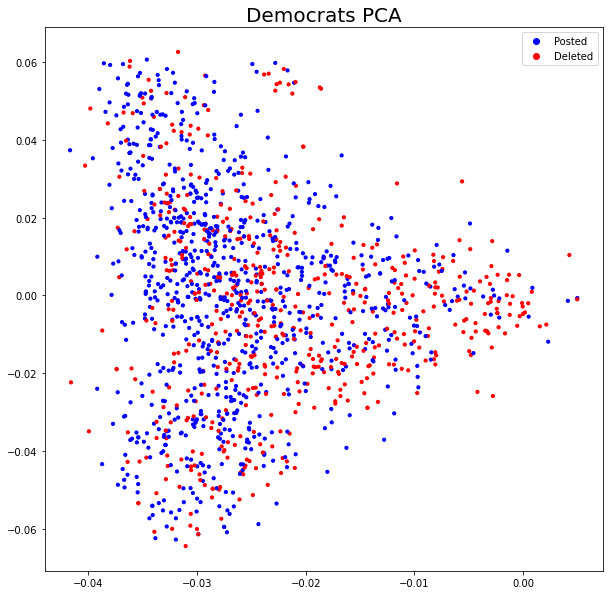

In [42]:
%matplotlib inline
scatterplot(df = democrats_df, path = plot_path,
            #path = plot_path + "PCA_removal/",
            file_name = "Democrats_PCA", main_title = "Democrats PCA",
            labels = ["Posted","Deleted"], colors =["blue","red"],
            display_plot = True)

In [43]:
subr_list = S["subreddit"].unique().tolist()

In [44]:
#for s in subr_list:
#        subr_df = PCA_data(s)
#        scatterplot(df = subr_df, path = plot_path + "PCA_removal/",
#               file_name = s + "_PCA", main_title = s + " PCA",display_plot = False)

In [45]:
def all_subreddits_pca_plot(plot_path, removal_variable_string = "removed", subr_list = subr_list,
                           labels = ["Posted","Deleted"], colors =["blue","red"]):
    for s in subr_list:
        #Get PCA Data
        print(s)
        subr_df = PCA_data(s)
        # Add Color Variable
        subr_df["color"] = "blue"
        subr_df.loc[subr_df[removal_variable_string]==1 , "color"]= "red"
        # Plot
        scatterplot(df = subr_df, path = plot_path,
               file_name = s + "_PCA_" + removal_variable_string, 
                    main_title = s + " PCA " + removal_variable_string,
                    labels = labels, colors = colors,
                    display_plot = False)

In [20]:
removed_var_list = ["removed_automod","removed_deleted","removed_moderator","removed_reddit"]
removed_var_list

['removed_automod', 'removed_deleted', 'removed_moderator', 'removed_reddit']

In [65]:
#Automod
all_subreddits_pca_plot(plot_path = plot_path + "PCA_removal/automod/",
                       removal_variable_string = removed_var_list[0], #'removed_automod',
                       subr_list = subr_list)

Michigan
(512, 765)
PoliticalVideo
(512, 1046)
The_Mueller
(512, 2173)
bayarea
(512, 1358)
conservatives
(512, 1537)
florida
(512, 899)
healthcare
(512, 1429)
skeptic
(512, 541)
tech
(512, 1965)
usanews
(512, 1031)
CanadaPolitics
(512, 1170)
ChapoTrapHouse
(512, 31018)
China
(512, 3182)
China_Flu
(512, 7484)
Conservative
(512, 8596)
CoronavirusMemes
(512, 852)
DrainTheSwamp
(512, 1205)
Economics
(512, 1469)
EverythingScience
(512, 1089)
Futurology
(512, 2715)
Health
(512, 4290)
IndiaSpeaks
(512, 7284)
LateStageCapitalism
(512, 3534)
Libertarian
(512, 4249)
POLITIC
(512, 13209)
POTUSWatch
(512, 1461)
Republican
(512, 1420)
SEO
(512, 2888)
SeattleWA
(512, 1565)
Sino
(512, 2105)
TechNewsToday
(512, 699)
TheNewRight
(512, 815)
USNEWS
(512, 715)
UpliftingNews
(512, 3097)
WayOfTheBern
(512, 8397)
atheism
(512, 5350)
australia
(512, 12873)
business
(512, 11519)
canada
(512, 4316)
collapse
(512, 2403)
conspiracy
(512, 10852)
dataisbeautiful
(512, 3382)
democrats
(512, 1439)
economy
(512, 1271)

In [66]:
#Deleted
all_subreddits_pca_plot(plot_path = plot_path + "PCA_removal/deleted/",
                       removal_variable_string = removed_var_list[1], #'removed_deleted'
                       subr_list = subr_list)

Michigan
(512, 765)
PoliticalVideo
(512, 1046)
The_Mueller
(512, 2173)
bayarea
(512, 1358)
conservatives
(512, 1537)
florida
(512, 899)
healthcare
(512, 1429)
skeptic
(512, 541)
tech
(512, 1965)
usanews
(512, 1031)
CanadaPolitics
(512, 1170)
ChapoTrapHouse
(512, 31018)
China
(512, 3182)
China_Flu
(512, 7484)
Conservative
(512, 8596)
CoronavirusMemes
(512, 852)
DrainTheSwamp
(512, 1205)
Economics
(512, 1469)
EverythingScience
(512, 1089)
Futurology
(512, 2715)
Health
(512, 4290)
IndiaSpeaks
(512, 7284)
LateStageCapitalism
(512, 3534)
Libertarian
(512, 4249)
POLITIC
(512, 13209)
POTUSWatch
(512, 1461)
Republican
(512, 1420)
SEO
(512, 2888)
SeattleWA
(512, 1565)
Sino
(512, 2105)
TechNewsToday
(512, 699)
TheNewRight
(512, 815)
USNEWS
(512, 715)
UpliftingNews
(512, 3097)
WayOfTheBern
(512, 8397)
atheism
(512, 5350)
australia
(512, 12873)
business
(512, 11519)
canada
(512, 4316)
collapse
(512, 2403)
conspiracy
(512, 10852)
dataisbeautiful
(512, 3382)
democrats
(512, 1439)
economy
(512, 1271)

In [67]:
#Moderator
all_subreddits_pca_plot(plot_path = plot_path + "PCA_removal/moderator/",
                       removal_variable_string = removed_var_list[2], # 'removed_moderator'
                       subr_list = subr_list)

Michigan
(512, 765)
PoliticalVideo
(512, 1046)
The_Mueller
(512, 2173)
bayarea
(512, 1358)
conservatives
(512, 1537)
florida
(512, 899)
healthcare
(512, 1429)
skeptic
(512, 541)
tech
(512, 1965)
usanews
(512, 1031)
CanadaPolitics
(512, 1170)
ChapoTrapHouse
(512, 31018)
China
(512, 3182)
China_Flu
(512, 7484)
Conservative
(512, 8596)
CoronavirusMemes
(512, 852)
DrainTheSwamp
(512, 1205)
Economics
(512, 1469)
EverythingScience
(512, 1089)
Futurology
(512, 2715)
Health
(512, 4290)
IndiaSpeaks
(512, 7284)
LateStageCapitalism
(512, 3534)
Libertarian
(512, 4249)
POLITIC
(512, 13209)
POTUSWatch
(512, 1461)
Republican
(512, 1420)
SEO
(512, 2888)
SeattleWA
(512, 1565)
Sino
(512, 2105)
TechNewsToday
(512, 699)
TheNewRight
(512, 815)
USNEWS
(512, 715)
UpliftingNews
(512, 3097)
WayOfTheBern
(512, 8397)
atheism
(512, 5350)
australia
(512, 12873)
business
(512, 11519)
canada
(512, 4316)
collapse
(512, 2403)
conspiracy
(512, 10852)
dataisbeautiful
(512, 3382)
democrats
(512, 1439)
economy
(512, 1271)

In [68]:
#Reddit
all_subreddits_pca_plot(plot_path = plot_path + "PCA_removal/reddit/",
                       removal_variable_string = removed_var_list[3],# 'removed_reddit'
                       subr_list = subr_list)

Michigan
(512, 765)
PoliticalVideo
(512, 1046)
The_Mueller
(512, 2173)
bayarea
(512, 1358)
conservatives
(512, 1537)
florida
(512, 899)
healthcare
(512, 1429)
skeptic
(512, 541)
tech
(512, 1965)
usanews
(512, 1031)
CanadaPolitics
(512, 1170)
ChapoTrapHouse
(512, 31018)
China
(512, 3182)
China_Flu
(512, 7484)
Conservative
(512, 8596)
CoronavirusMemes
(512, 852)
DrainTheSwamp
(512, 1205)
Economics
(512, 1469)
EverythingScience
(512, 1089)
Futurology
(512, 2715)
Health
(512, 4290)
IndiaSpeaks
(512, 7284)
LateStageCapitalism
(512, 3534)
Libertarian
(512, 4249)
POLITIC
(512, 13209)
POTUSWatch
(512, 1461)
Republican
(512, 1420)
SEO
(512, 2888)
SeattleWA
(512, 1565)
Sino
(512, 2105)
TechNewsToday
(512, 699)
TheNewRight
(512, 815)
USNEWS
(512, 715)
UpliftingNews
(512, 3097)
WayOfTheBern
(512, 8397)
atheism
(512, 5350)
australia
(512, 12873)
business
(512, 11519)
canada
(512, 4316)
collapse
(512, 2403)
conspiracy
(512, 10852)
dataisbeautiful
(512, 3382)
democrats
(512, 1439)
economy
(512, 1271)

In [48]:
#All together now
for s in subr_list:
        #Get PCA Data
        print(s)
        subr_df = PCA_data(s)
        # Add Color Variable
        subr_df["color"] = "blue"
        subr_df.loc[subr_df[removed_var_list[0]]==1 , "color"]= "red"
        subr_df.loc[subr_df[removed_var_list[1]]==1 , "color"]= "green"
        subr_df.loc[subr_df[removed_var_list[2]]==1 , "color"]= "black"
        subr_df.loc[subr_df[removed_var_list[3]]==1 , "color"]= "yellow"
        # Plot
        scatterplot(df = subr_df, path = plot_path + "PCA_removal/overall_colored/",
               file_name = s + "_PCA_", 
                    main_title = s + " PCA ",
                     labels = ["Posted","Automod","Deleted","Moderator","Reddit"], 
                    colors =["blue","red","green","black","yellow"],
                    display_plot = False)

Michigan
(512, 765)
PoliticalVideo
(512, 1046)
The_Mueller
(512, 2173)
bayarea
(512, 1358)
conservatives
(512, 1537)
florida
(512, 899)
healthcare
(512, 1429)
skeptic
(512, 541)
tech
(512, 1965)
usanews
(512, 1031)
CanadaPolitics
(512, 1170)
ChapoTrapHouse
(512, 31018)
China
(512, 3182)
China_Flu
(512, 7484)
Conservative
(512, 8596)
CoronavirusMemes
(512, 852)
DrainTheSwamp
(512, 1205)
Economics
(512, 1469)
EverythingScience
(512, 1089)
Futurology
(512, 2715)
Health
(512, 4290)
IndiaSpeaks
(512, 7284)
LateStageCapitalism
(512, 3534)
Libertarian
(512, 4249)
POLITIC
(512, 13209)
POTUSWatch
(512, 1461)
Republican
(512, 1420)
SEO
(512, 2888)
SeattleWA
(512, 1565)
Sino
(512, 2105)
TechNewsToday
(512, 699)
TheNewRight
(512, 815)
USNEWS
(512, 715)
UpliftingNews
(512, 3097)
WayOfTheBern
(512, 8397)
atheism
(512, 5350)
australia
(512, 12873)
business
(512, 11519)
canada
(512, 4316)
collapse
(512, 2403)
conspiracy
(512, 10852)
dataisbeautiful
(512, 3382)
democrats
(512, 1439)
economy
(512, 1271)

In [ ]:
#CONCLUSION Overall: No visible pattern in deletion behaviour.
# Wtf. 
# Next Steps
# --> s0: turn off plotting with matplotlib CHECK
# https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
# --> s1: do it for each of the removal types separatly (is it the data)
# --> s2: SVD instead of PCA (or is it the analysis?)
# --> s3: different embeddings

In [ ]:
# CONCLUSION INDIVIDUAL:
#ROBERT: worldnews_ removed deleted : Punkte sind alle IM blauen bereich
# 
# --> CanadaPolitics removed_reddit ist im Ansatz was ich will
# --> healthIT PCA removed_reddit ist GENAU was ich will
# --> "UplifitngNews" ?
# --> Australia removed_reddit
# --> CanadaPolitics removed_reddit
# --> Economy removed_reddit
# --> environment removed_reddit,
# --> florida, Futurology removed_reddit
#
# --> POTUSWatch removed_automod
# --> toronto removed_automod ?
# --> Conservative removed_automod
# --> Canada removed_automod
#
# --> canada removed_deleted
# --> environment removed_deleted
# --> POLITICS removed_deleted
# --> Rebulican removed_deleted
# --> skeptic removed_deleted ? 
# --> The_Mueller removed_deleted
# --> unitedkingdom removed_deleted
#
# --> China removed_moderator
# --> dataisbeautiful removed_moderator
# --> environment removed_moderator ?
# --> florida removed_moderator ?
# --> healthcare removed_moderator ? 
# --> healthIT removed_moderator
# --> indianews removed_moderator ? 
# --> maryland removed_moderator circle
# --> Michigan removed_moderator circle
# --> neoliberal removed_moderator ? 
# --> nyc removed_moderator
# --> ontario removed_moderator ?
# --> ottawa removed_moderator
# --> POTUSWatch removed_moderator
# --> Republican removed_moderator
# --> science removed_moderator
# --> singapore removed_moderator
# --> Sino removed_moderator
# --> technology removed_moderator
# --> USNEWS removed_moderator ? 
# --> worldnews removed_moderator ?

In [ ]:
#CONCLUSION OVERALL COLORED:
# --> usanews 
# --> CanadaPolitics
# --> Conservative 
# -->  Futurology 
# --> Repulican 
# --> SEO
# --> Uplifting
# --> Worldnews
# --> unitedkingdoms PCA
# --> technology
# --> singapore
# --> Seattle
#  --> news
# --> Libertarian
# --> India
# --> Ottawa

In [ ]:
#TO DO:
# Third variables / Technical
# --> Understand Deletion types (what is removed_ reddit) (!!!!!!)
# --> qualitative look for words
# --> third variables (one certain link, news source?)
# --> key words
# --> technical (embedding)
# --> logit/ svm for quantification
#
# Theoretical / vague:
# --> Network Sample of Moderator
# --> Homogeneity  of People who put submissions / commentators
# --> Douglas Theory
# --> Norms 
#
#Presentaiton by friday:
# --> Word file as hand in before that
# --> Formulate: Next step on the network sample
# --> Submissions before/after Corona
#
#Further Thoughts
# --> Do the boundaries depend on the "structure" (e.g line) of the SVD cloud?

In [ ]:
#PROBLEM: Kann keine Information zu den deletion cateogries finden:
# QUELLEN:
# [1] https://readthedocs.org/projects/reddit-api/downloads/pdf/latest/
# [2] https://psaw.readthedocs.io/en/latest/index.html
# [3] https://pushshift.io/api-parameters/
# [4] https://github.com/pushshift/reddit_sse_stream/issues/14
# [5] https://www.reddit.com/r/undelete/comments/eegrdk/so_is_the_bot_basically_dead_this_subreddit/

In [20]:
#----------------------------#
# 3.)  Approach 1: Logit Boundaries
#----------------------------#
# https://datascience.stackexchange.com/questions/49573/how-to-plot-logistic-regression-decision-boundary
# https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression